# Create model arquitecture

In [70]:
from tensorflow.keras import layers
from tensorflow import keras, dtypes
from tensorflow.data import Dataset
from tensorflow import feature_column
import tensorflow as tf

from preprocess_tf import preprocessing_fn

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import random
import os

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value

os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value

random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)


tf.keras.backend.set_floatx('float32')

In [72]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, target_name, shuffle=True, batch_size=100):
    dataframe = dataframe.copy()
    targets = dataframe.pop(target_name)
    ds = Dataset.from_tensor_slices((dict(dataframe), targets))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

In [73]:
def r2_score(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1 - ss_res/ss_tot
    return r2

In [74]:
def set_numerical_feature(name):
    
    numerical_feature = feature_column.numeric_column(name, dtype=dtypes.float32)
    
    return numerical_feature
    
def set_one_hot_feature(name, data):
    one_hot_feature = feature_column.categorical_column_with_vocabulary_list(name, data[name].unique().tolist())
    one_hot_feature = feature_column.indicator_column(one_hot_feature)
    
    return one_hot_feature

def set_embedding_feature(name, data, dims):
    embedding_feature = feature_column.categorical_column_with_vocabulary_list(name, data[name].unique().tolist())
    embedding_feature = feature_column.embedding_column(embedding_feature, dimension=dims)
    
    return embedding_feature

In [75]:
def feature_columns(data, dataset):
    
    feature_columns = []

    # numeric cols
    for header in ['yearOfRegistration', 'powerPS', 'kilometer']:
        feature_columns.append(set_numerical_feature(header))
        
    feature_columns.append(set_one_hot_feature('abtest', data))
    
    feature_columns.append(set_one_hot_feature('vehicleType', data))
    
    feature_columns.append(set_one_hot_feature('gearbox', data))
    
    feature_columns.append(set_one_hot_feature('fuelType', data))
    
    feature_columns.append(set_one_hot_feature('brand', data))
    
#     feature_columns.append(set_one_hot_feature('model', data))

    feature_columns.append(set_one_hot_feature('cluster_model', data))
    
    feature_columns.append(set_one_hot_feature('notRepairedDamage', data))
    
    
    feature_layer = layers.DenseFeatures(feature_columns)
    
    return(feature_layer)

In [76]:
train = preprocessing_fn(
    path='data/train.csv',
    na_encoding='data/gearbox_powerps_na.csv',
    norm_params='data/numerical_features_normalization.csv',
    brand_clusters='data/brand_clusters.csv',
    model_clusters='data/model_clusters.csv',
    postalcode_clusters='data/postalcode_clusters.csv'
)
val = preprocessing_fn(
    path='data/val.csv',
    na_encoding='data/gearbox_powerps_na.csv',
    norm_params='data/numerical_features_normalization.csv',
    brand_clusters='data/brand_clusters.csv',
    model_clusters='data/model_clusters.csv',
    postalcode_clusters='data/postalcode_clusters.csv'
)
test = preprocessing_fn(
    path='data/test.csv',
    na_encoding='data/gearbox_powerps_na.csv',
    norm_params='data/numerical_features_normalization.csv',
    brand_clusters='data/brand_clusters.csv',
    model_clusters='data/model_clusters.csv',
    postalcode_clusters='data/postalcode_clusters.csv'
)

train = train.dropna()
val = val.dropna()
test = test.dropna()

print(train.shape)
print(val.shape)
print(test.shape)

(88266, 11)
(22093, 11)
(47219, 11)


In [77]:
train.dtypes

price                   int64
abtest                 object
vehicleType            object
yearOfRegistration    float32
gearbox                object
powerPS               float32
kilometer             float32
fuelType               object
brand                  object
notRepairedDamage      object
cluster_model           int32
dtype: object

In [78]:
train_ds = df_to_dataset(dataframe=train, target_name='price', shuffle=True, batch_size=512)
val_ds = df_to_dataset(dataframe=val, target_name='price', shuffle=True, batch_size=512)
test_ds = df_to_dataset(dataframe=test, target_name='price', shuffle=True, batch_size=512)

In [79]:
feature_layer = feature_columns(train, train_ds)

Epoch 1/100
173/173 [==============================] - 2s 12ms/step - loss: 2689.0791 - mean_absolute_error: 2689.0791 - mean_squared_error: 23841300.0000 - val_loss: 1462.5696 - val_mean_absolute_error: 1462.5696 - val_mean_squared_error: 13607576.0000
Epoch 2/100
173/173 [==============================] - 2s 10ms/step - loss: 1357.7007 - mean_absolute_error: 1357.7007 - mean_squared_error: 12144534.0000 - val_loss: 1210.9923 - val_mean_absolute_error: 1210.9923 - val_mean_squared_error: 13126526.0000
Epoch 3/100
173/173 [==============================] - 2s 10ms/step - loss: 1241.4844 - mean_absolute_error: 1241.4844 - mean_squared_error: 8551397.0000 - val_loss: 1101.0637 - val_mean_absolute_error: 1101.0637 - val_mean_squared_error: 5572199.5000
Epoch 4/100
173/173 [==============================] - 2s 9ms/step - loss: 1171.8784 - mean_absolute_error: 1171.8784 - mean_squared_error: 5232381.5000 - val_loss: 1050.5747 - val_mean_absolute_error: 1050.5747 - val_mean_squared_error: 43

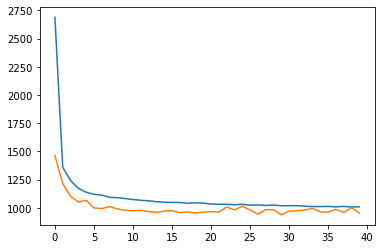

In [80]:
dp_rate = 0.1
lr = 0.001
hu = 60
momentum = 0.9

model = keras.Sequential([
    feature_layer,
    layers.Dense(hu),
    layers.Activation('relu'),
    #layers.BatchNormalization(momentum=momentum),
    layers.Dropout(rate=dp_rate),
    layers.Dense(hu),
    layers.Activation('relu'),
    #layers.BatchNormalization(momentum=momentum),
    layers.Dropout(rate=dp_rate),
    layers.Dense(hu),
    layers.Activation('relu'),
    #layers.BatchNormalization(momentum=momentum),
    layers.Dropout(rate=dp_rate),
    layers.Dense(hu),
    layers.Activation('relu'),
    #layers.BatchNormalization(momentum=momentum),
    layers.Dropout(rate=dp_rate),
    layers.Dense(hu),
    layers.Activation('relu'),
    #layers.BatchNormalization(momentum=momentum),
    layers.Dropout(rate=dp_rate),
    layers.Dense(hu),
    layers.Activation('relu'),
    layers.Dense(1, activation='relu')
])

# Compile Keras model
model.compile(
    loss='mean_absolute_error',
    metrics=['mean_squared_error'],
    optimizer=keras.optimizers.Adam(learning_rate=lr))

# fit model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)]
)

# get results
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

plt.plot(hist.epoch, hist.mean_absolute_error)
plt.plot(hist.epoch, hist.val_mean_absolute_error)
plt.show()

In [81]:
hist.tail(10)

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
30,1017.445068,1017.445068,3672796.25,969.800598,969.800598,3467343.75,30
31,1018.067505,1018.067505,3829794.00,973.839111,973.839111,3498159.75,31
32,1013.220032,1013.220032,3696410.50,978.654846,978.654846,3524989.75,32
33,1010.019165,1010.019165,3641124.75,994.501038,994.501038,3577792.25,33
34,1009.962708,1009.962708,3636054.00,962.927368,962.927368,3470430.25,34
35,1011.479126,1011.479126,3630507.25,960.610901,960.610901,3386299.00,35
36,1007.235657,1007.235657,3694896.25,985.940369,985.940369,3560098.25,36
37,1011.438538,1011.438538,3666133.25,956.492920,956.492920,3405354.75,37
38,1005.799561,1005.799561,3656111.25,1001.172058,1001.172058,3628669.75,38
39,1007.769226,1007.769226,3573632.00,950.763794,950.763794,3381483.25,39


In [82]:
model.save('model/model.h5')

In [83]:
# Validation results
print('VALIDATION RESULTS\n')
val_pred = model.predict(df_to_dataset(dataframe=val, target_name='price', shuffle=False, batch_size=1000)).flatten()

val['price_pred'] = val_pred
val['abs_error'] = abs(val.price_pred - val.price)
val['error'] = val.price_pred - val.price

# super baseline model
print('baseline abs error: ' + str(np.mean(np.abs(val.price - train.price.mean()))))

# my model
print('model abs error: ' + str(np.mean(np.abs(val.price - val_pred))))

# r squared
print('model r2: ' + str(r2_score(val.price, val.price_pred)))

VALIDATION RESULTS

baseline abs error: 3515.769520968634
model abs error: 950.7638595485053
model r2: 0.8735864294496808


In [84]:
# Test results
print('TEST RESULTS\n')
test_pred = model.predict(df_to_dataset(dataframe=test, target_name='price', shuffle=False, batch_size=1000)).flatten()

test['price_pred'] = test_pred
test['abs_error'] = abs(test.price_pred - test.price)
test['error'] = test.price_pred - test.price

worst_predictions = test.copy().loc[test.abs_error >= test.abs_error.quantile(0.9)]

# super baseline model
print('baseline abs error: ' + str(np.mean(np.abs(test.price - train.price.mean()))))

# my model
print('model abs error: ' + str(np.mean(np.abs(test.price - test_pred))))

# r squared
print('model r2: ' + str(r2_score(test.price, test.price_pred)))

TEST RESULTS

baseline abs error: 3519.359949713082
model abs error: 947.1436171483912
model r2: 0.8743153896581684


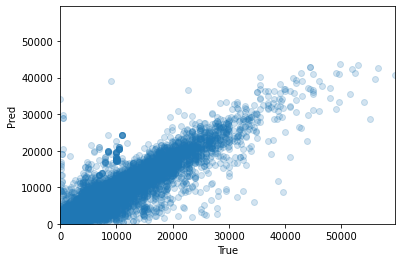

In [85]:
plt.scatter(test.price, test_pred, alpha=0.2)
plt.xlim([0, test.price.max()])
plt.ylim([0, test.price.max()])
plt.xlabel('True')
plt.ylabel('Pred')
plt.show()

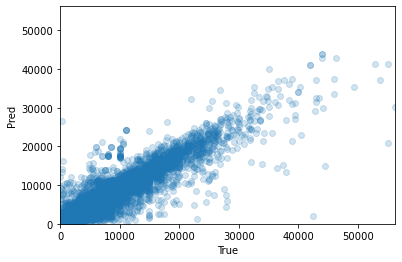

In [86]:
plt.scatter(val.price, val_pred, alpha=0.2)
plt.xlim([0, val.price.max()])
plt.ylim([0, val.price.max()])
plt.xlabel('True')
plt.ylabel('Pred')
plt.show()

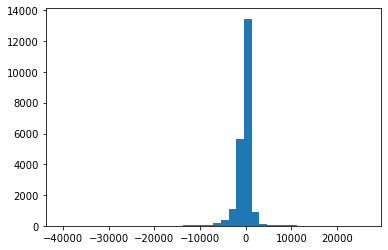

In [87]:
plt.hist(val.error, bins=40)
plt.show()

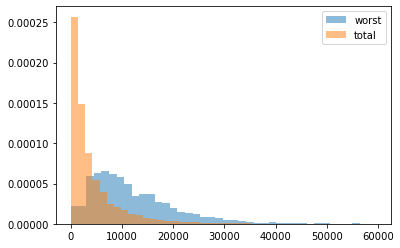

In [88]:
plt.hist(worst_predictions.price, bins=40, alpha=0.5, density=True, label='worst')
plt.hist(val.price, bins=40, alpha=0.5, density=True, label='total')
plt.legend()
plt.show()

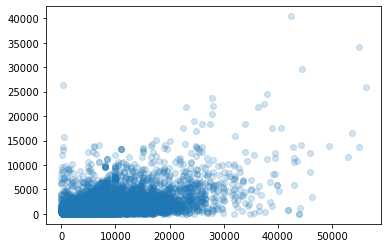

In [89]:
plt.scatter(val.price, val.abs_error, alpha=0.2)
plt.show()

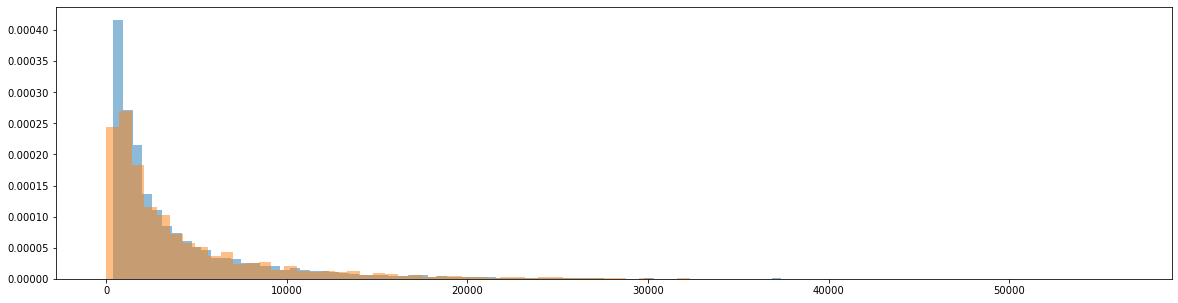

In [90]:
plt.figure(figsize=(20,5))
plt.hist(val.price_pred, bins=80, alpha=0.5, density=True)
plt.hist(val.price, bins=80, alpha=0.5, density=True)
plt.show()

In [91]:
test.price.max()

59500

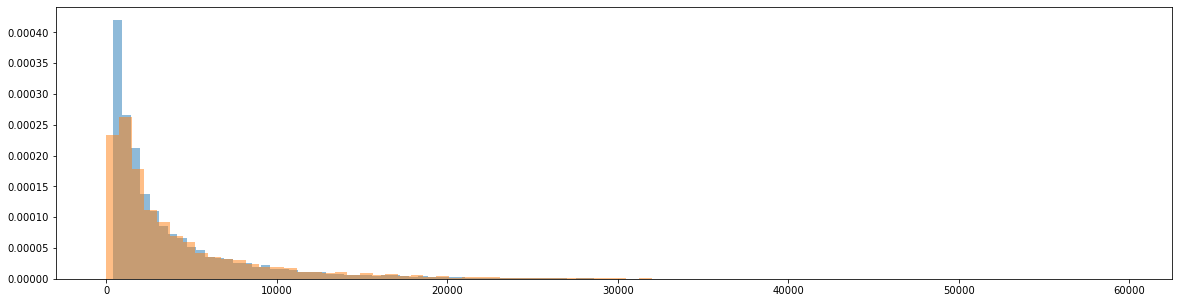

In [92]:
plt.figure(figsize=(20,5))
plt.hist(test.price_pred, bins=80, alpha=0.5, density=True)
plt.hist(test.price, bins=80, alpha=0.5, density=True)
plt.show()